In [1]:
import numpy as np
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap, projection_params
from plotstokesQ_U import plotstokesQ_U


In [2]:
filepath = '/Volumes/Data1/mwa_healpix/diffuse_survey_4pol/'
obsid_list = [1130781304, 1130789944, 1131454296]
obsid = obsid_list[1]
q_file = filepath + str(obsid) + '_uniform_Residual_Q_HEALPix.fits'
u_file = filepath + str(obsid) + '_uniform_Residual_U_HEALPix.fits'

In [125]:
contents_Q = fits.open(q_file)
data_Q = contents_Q[1].data
nside_Q = contents_Q[1].header['nside']
ordering_Q = contents_Q[1].header['ordering']
contents_U = fits.open(u_file)
data_U = contents_U[1].data
nside_U = contents_U[1].header['nside']
ordering_U = contents_U[1].header['ordering']

In [126]:
pixels_Q = data_Q.field('PIXEL')
signal_Q = data_Q.field('SIGNAL')
pixels_U = data_U.field('PIXEL')
signal_U = data_U.field('SIGNAL')

In [127]:
ordering_Q.lower()

'nested'

In [128]:
if ordering_Q.lower() == 'ring':
    ra, dec = hp.pixelfunc.pix2ang(int(nside_Q), pixels_Q, nest=False, lonlat=True)
if ordering_Q.lower() == 'nested':
    ra, dec = hp.pixelfunc.pix2ang(int(nside_Q), pixels_Q, nest=True, lonlat=True)

In [129]:
min_ra = np.min(ra)
print min_ra
max_ra = np.max(ra)
print max_ra
mean_ra = np.mean(ra)
min_dec = np.min(dec)
print min_dec
max_dec = np.max(dec)
print max_dec
mean_dec = np.mean(dec)

101.237430168
130.856584821
-57.2090826646
-37.215725446


In [185]:
proj_list = sorted(projection_params.keys())

In [186]:
print(proj_list)

['aea', 'aeqd', 'cass', 'cea', 'cyl', 'eck4', 'eqdc', 'gall', 'geos', 'gnom', 'hammer', 'kav7', 'laea', 'lcc', 'mbtfpq', 'merc', 'mill', 'moll', 'npaeqd', 'nplaea', 'npstere', 'nsper', 'omerc', 'ortho', 'poly', 'robin', 'rotpole', 'sinu', 'spaeqd', 'splaea', 'spstere', 'stere', 'tmerc', 'vandg']


In [263]:
print(proj_list[28:32])

['spaeqd', 'splaea', 'spstere', 'stere']


In [264]:
def make_plot(projection):
    print('{p} projection'.format(p=projection))    
    if 'no corners' in projection_params[projection]:
        if 'bounding_lat' in projection_params[projection]:
            if projection in ['nplaea', 'npstere', 'npaeqd']:
                # northern polar projection
                if max_dec < 0:
                    print('polar projection in wrong hemisphere: data is in the southern hemisphere')
                    boundinglat = 10
                else:
                    boundinglat = abs(min_dec)
            else:
                # southern polar projection
                if max_dec > 0:
                    print('polar projection in wrong hemisphere: data is in the northern hemisphere')
                    boundinglat = -10
                else:
                    boundinglat = max_dec
                   
            m = Basemap(projection=projection, lon_0=mean_ra, boundinglat=boundinglat, resolution=None)
        else:
            # examples are 'moll', 'hammer', 'eck4'
            print('corners are not supported in this projection')
            # these projections can only make full-globe maps, any corner information is ignored
            m = Basemap(projection=projection, lon_0=mean_ra, lat_0=mean_dec, resolution=None)
    elif 'llcrnrx' in projection_params[projection]:
        # example is 'orth'
        # can't use llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat even though the docs say you can
        # you also can't use width or height even though the docs say you can
        # you have to use llcrnrx, llcrnry, urcrnrx, urcrnry but I'm not sure how to calculate them....
        # these numbers are based on some online examples and experimentation
        deg_scale_factor = 120000
        llcrnrx = -1 * (max_ra - min_ra) * deg_scale_factor / 2
        urcrnrx = (max_ra - min_ra) * deg_scale_factor / 2
        if projection not in ['geos']:
            llcrnry = -1 * (max_dec - min_dec) * deg_scale_factor / 2
            urcrnry = (max_dec - min_dec) * deg_scale_factor / 2
            m = Basemap(projection=projection, lon_0=np.mean(ra), lat_0=np.mean(dec), resolution=None,
                        llcrnrx=llcrnrx, llcrnry=llcrnry, urcrnrx=urcrnrx, urcrnry=urcrnry)
        else:
            # need a new scale factor for some reason
            deg_scale_factor = 175000
            llcrnry = min_dec * deg_scale_factor / 2
            urcrnry = max_dec * deg_scale_factor / 2
            m = Basemap(projection=projection, lon_0=np.mean(ra), resolution=None,
                        llcrnrx=llcrnrx, llcrnry=llcrnry, urcrnrx=urcrnrx, urcrnry=urcrnry)
    elif 'lat_1,lat_2,lon_1,lon_2' in projection_params[projection]:
        m = Basemap(projection=projection, lon_0=mean_ra, lat_0=mean_dec,
                    lon_1=mean_ra, lat_1=min_dec, lon_2=mean_ra, lat_2=max_dec,
                    llcrnrlon=min_ra, llcrnrlat=min_dec, urcrnrlon=max_ra, urcrnrlat=max_dec, resolution=None)
    elif 'lon_0' in projection_params[projection]:
        if projection in ['rotpole']:
            m = Basemap(projection=projection, lon_0=np.mean(ra), lat_0=np.mean(dec), o_lat_p=0, o_lon_p=0,
                        llcrnrlon=min_ra, llcrnrlat=min_dec, urcrnrlon=max_ra, urcrnrlat=max_dec, resolution=None)            
        else:
            # example: 'aeqd'
            m = Basemap(projection=projection, lon_0=np.mean(ra), lat_0=np.mean(dec),
                        llcrnrlon=min_ra, llcrnrlat=min_dec, urcrnrlon=max_ra, urcrnrlat=max_dec, resolution=None)
    else:
        m = Basemap(projection=projection, llcrnrlon=min_ra, llcrnrlat=min_dec,
                    urcrnrlon=max_ra, urcrnrlat=max_dec, resolution=None)
    fig = plt.figure()
    x, y = m(ra, dec)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    if projection in ['ortho']:
        m.drawparallels(np.arange(-90., 120., 10.))
    else:
        m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
    if projection in ['moll', 'hammer']:
        m.drawmeridians(np.arange(0., 420., 10.))
    else:
        m.drawmeridians(np.arange(0., 420., 10.), labels=[0, 0, 0, 1])
    m.scatter(x, y, 3, marker='o', linewidths=.1, c=signal_Q, cmap=plt.cm.coolwarm)
    m.colorbar()
    plt.show()

spaeqd projection


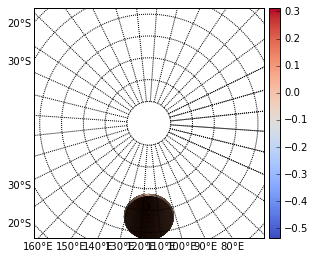

splaea projection


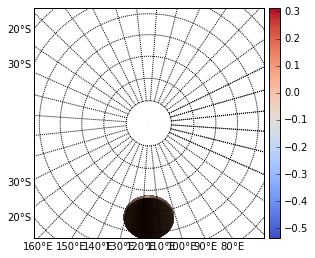

spstere projection


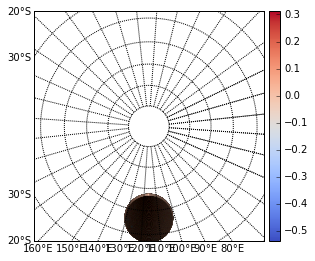

stere projection


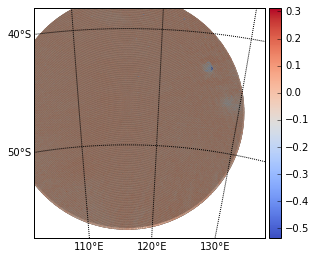

In [265]:
for p in proj_list[28:32]:
    make_plot(p)

In [140]:
projection_params

{'aea': 'lon_0,lat_0,lat_1',
 'aeqd': 'lon_0,lat_0',
 'cass': 'lon_0,lat_0',
 'cea': 'corners only plus lat_ts (no width/height)',
 'cyl': 'corners only (no width/height)',
 'eck4': 'lon_0,lat_0,no corners or width/height',
 'eqdc': 'lon_0,lat_0,lat_1,lat_2',
 'gall': 'corners only (no width/height)',
 'geos': 'lon_0,satellite_height,llcrnrx,llcrnry,urcrnrx,urcrnry,no width/height',
 'gnom': 'lon_0,lat_0',
 'hammer': 'lon_0,lat_0,no corners or width/height',
 'kav7': 'lon_0,lat_0,no corners or width/height',
 'laea': 'lon_0,lat_0',
 'lcc': 'lon_0,lat_0,lat_1,lat_2,k_0',
 'mbtfpq': 'lon_0,lat_0,no corners or width/height',
 'merc': 'corners plus lat_ts (no width/height)',
 'mill': 'corners only (no width/height)',
 'moll': 'lon_0,lat_0,no corners or width/height',
 'npaeqd': 'bounding_lat,lon_0,lat_0,no corners or width/height',
 'nplaea': 'bounding_lat,lon_0,lat_0,no corners or width/height',
 'npstere': 'bounding_lat,lon_0,lat_0,no corners or width/height',
 'nsper': 'lon_0,satellite_

rotpole projection


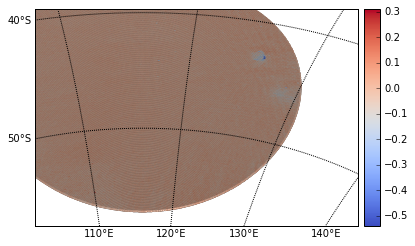

In [259]:
make_plot('rotpole')

In [190]:
for p, desc in projection_params.iteritems():
    if 'llcrnrx' in desc:
        print(p, desc)
        if 'lat_0' not in desc:
            print('no lat_0')

('geos', 'lon_0,satellite_height,llcrnrx,llcrnry,urcrnrx,urcrnry,no width/height')
no lat_0
('nsper', 'lon_0,satellite_height,llcrnrx,llcrnry,urcrnrx,urcrnry,no width/height')
no lat_0
('ortho', 'lon_0,lat_0,llcrnrx,llcrnry,urcrnrx,urcrnry,no width/height')


In [218]:
print(1200000*2/20.)

120000.0


In [217]:
print(max_dec-min_dec)

19.9933572186
